# Sathwik Kamath 
### E-mail:kamathsathwik18@gmail.com
### LinkedIn: www.linkedin.com/in/sathwik-kamath
### Github: https://github.com/SathwikKamath

In [1]:
import os
from pyspark.sql import SparkSession

# Set Java and Hadoop paths (needed for Spark to run locally on Windows)
os.environ["JAVA_HOME"] = "D:/openjdk-11.0.0.2_windows-x64/jdk-11.0.0.2"
os.environ["HADOOP_HOME"] = "D:/hadoop"

# Create Spark Session with MySQL JDBC Connector
spark = (
    SparkSession.builder
    .appName("HeartDiseasePipeline")
    .master("local[*]")  # Use all cores of your CPU
    .config("spark.jars", "file:///D:/mysql-connector-j-9.3.0/mysql-connector-j-9.3.0.jar")  # MySQL driver
    .config("spark.driver.extraClassPath", "D:/mysql-connector-j-9.3.0/mysql-connector-j-9.3.0.jar")
    .getOrCreate()
)


In [2]:
# MySQL database details
jdbc_url = "jdbc:mysql://localhost:3306/heart_db"
props = {"user": "root", "password": "Kamath@2001"}

# Read data from MySQL table 'heart_data'
df = spark.read.jdbc(url=jdbc_url, table="cleveland_heart_disease", properties=props)

# Display schema and first few rows
print("\nSchema of the data:")
df.printSchema()
print("\nFirst 5 rows:")
df.show(5)



Schema of the data:
root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- cp: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- chol: double (nullable = true)
 |-- fbs: double (nullable = true)
 |-- restecg: double (nullable = true)
 |-- thalach: double (nullable = true)
 |-- exang: double (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: double (nullable = true)
 |-- ca: double (nullable = true)
 |-- thal: double (nullable = true)
 |-- target: long (nullable = true)


First 5 rows:
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+------+
| age|sex| cp|trestbps| chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+------+
|63.0|1.0|1.0|   145.0|233.0|1.0|    2.0|  150.0|  0.0|    2.3|  3.0|0.0| 6.0|     0|
|67.0|1.0|4.0|   160.0|286.0|0.0|    2.0|  108.0|  1.0|    1.5|  2.0|3.0| 3.0|     2|
|67.0|1.0|4.0|  

In [3]:
from pyspark.sql.functions import col, when, sum as Fsum
# Step 2: Create a column for each feature with 1 if null, else 0
missing_count = df.select([
    when(col(c).isNull(), 1).otherwise(0).alias(c)
    for c in df.columns
])

# Step 3: Sum nulls per column
missing_sum = missing_count.agg(
    *[Fsum(col(c)).alias(c) for c in missing_count.columns]
)

# Step 4: Show missing values per column
missing_sum.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  4|   2|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+



In [4]:
# Step 5: Total missing values across the entire dataset
total_missing = missing_sum.select(
    sum(missing_sum[c] for c in missing_sum.columns).alias("Total_Missing_Values")
)
total_missing.show()


+--------------------+
|Total_Missing_Values|
+--------------------+
|                   6|
+--------------------+



In [5]:
# Removing the missing value
df_dropna= df.dropna()
df_dropna.show()

+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+------+
| age|sex| cp|trestbps| chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+------+
|63.0|1.0|1.0|   145.0|233.0|1.0|    2.0|  150.0|  0.0|    2.3|  3.0|0.0| 6.0|     0|
|67.0|1.0|4.0|   160.0|286.0|0.0|    2.0|  108.0|  1.0|    1.5|  2.0|3.0| 3.0|     2|
|67.0|1.0|4.0|   120.0|229.0|0.0|    2.0|  129.0|  1.0|    2.6|  2.0|2.0| 7.0|     1|
|37.0|1.0|3.0|   130.0|250.0|0.0|    0.0|  187.0|  0.0|    3.5|  3.0|0.0| 3.0|     0|
|41.0|0.0|2.0|   130.0|204.0|0.0|    2.0|  172.0|  0.0|    1.4|  1.0|0.0| 3.0|     0|
|56.0|1.0|2.0|   120.0|236.0|0.0|    0.0|  178.0|  0.0|    0.8|  1.0|0.0| 3.0|     0|
|62.0|0.0|4.0|   140.0|268.0|0.0|    2.0|  160.0|  0.0|    3.6|  3.0|2.0| 3.0|     3|
|57.0|0.0|4.0|   120.0|354.0|0.0|    0.0|  163.0|  1.0|    0.6|  1.0|0.0| 3.0|     0|
|63.0|1.0|4.0|   130.0|254.0|0.0|    2.0|  147.0|  0.0

In [6]:
from pyspark.sql.functions import col, when, sum as Fsum
# Step 2: Create a column for each feature with 1 if null, else 0
missing_count = df_dropna.select([
    when(col(c).isNull(), 1).otherwise(0).alias(c)
    for c in df.columns
])

# Step 3: Sum nulls per column
missing_sum = missing_count.agg(
    *[Fsum(col(c)).alias(c) for c in missing_count.columns]
)

# Step 4: Show missing values per column
missing_sum.show()


+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+



In [7]:
from pyspark.sql.functions import col

# Convert all columns to numeric type (double)
for col_name in df.columns:
    df = df.withColumn(col_name, col(col_name).cast("double"))

# Check for missing values
print("\nCount of NULLs in each column:")
df.select([col(c).isNull().cast("int").alias(c) for c in df.columns]).show()



Count of NULLs in each column:
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
|  0|  0|  0|       0|   0|  0|      0|     

In [8]:
df_dropna.printSchema()

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- cp: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- chol: double (nullable = true)
 |-- fbs: double (nullable = true)
 |-- restecg: double (nullable = true)
 |-- thalach: double (nullable = true)
 |-- exang: double (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: double (nullable = true)
 |-- ca: double (nullable = true)
 |-- thal: double (nullable = true)
 |-- target: long (nullable = true)



# 1. Summary Statistics

In [9]:
# ✅ Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, corr
import pandas as pd
# ---------------------------
# 1. Summary Statistics
# ---------------------------
# Compute mean, std, min, max, count for all numeric columns

# Get summary statistics from PySpark
summary_df = df_dropna.describe().toPandas()

# Convert numeric columns from string to float
for col in summary_df.columns[1:]:  # skip "summary"
    summary_df[col] = pd.to_numeric(summary_df[col], errors='coerce')

# Round to 2 decimals
summary_df = summary_df.round(2)

summary_df

,summary,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,count,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00
1,mean,54.54,0.68,3.16,131.69,247.35,0.14,1.00,149.60,0.33,1.06,1.60,0.68,4.73,0.95
2,stddev,9.05,0.47,0.96,17.76,52.00,0.35,0.99,22.94,0.47,1.17,0.62,0.94,1.94,1.23
3,min,29.00,0.00,1.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,1.00,0.00,3.00,0.00
4,max,77.00,1.00,4.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,3.00,3.00,7.00,4.00


# 2. Plot Distributions

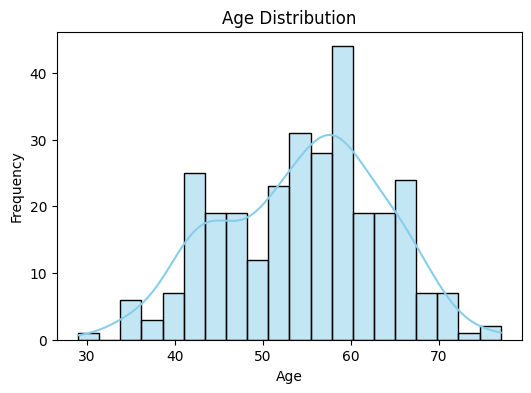

In [11]:
# ---------------------------
# 2. Plot Distributions
# ---------------------------
# Convert Spark DataFrame to Pandas for plotting
df_pandas = df_dropna.toPandas()

# Plot Age Distribution
plt.figure(figsize=(6,4))
sns.histplot(df_pandas["age"], bins=20, kde=True, color="skyblue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Graph Title: Age Distribution
## Axes:

X-axis (Age) → Age of patients in years.

Y-axis (Frequency) → Number of patients in each age group (how many people fall into each age bin).

## Interpretation:

Shape of Distribution:

The histogram shows a bell-shaped (nearly normal) distribution, centered around ages 50–60.

The KDE (blue curve) confirms that most patients fall in this middle-age to older range.

## Younger Patients (<40 years):

Very few patients are younger than 40.

This indicates heart disease in the dataset is less common in younger individuals.

## Middle-aged Patients (40–60 years):

The majority of patients are between 45 and 60 years old.

Frequency peaks around 55–60 years, where over 40 patients are represented in this bin.

This suggests that heart disease risk increases with age and is most common in middle-aged adults.

## Older Patients (>65 years):

There are fewer patients above 65 compared to the 50–60 range.

This could mean either fewer elderly individuals were part of the dataset or survival bias (those with severe disease may not reach advanced age).

# Key Insights:

Heart disease in this dataset mainly affects people between ages 45–65.

The dataset is not evenly distributed across ages (more middle-aged patients than very young/old).

Age is likely an important predictor for heart disease, but needs to be combined with other factors (cholesterol, BP, max heart rate, etc.) for accurate prediction.

# ✅ In simple terms:
This graph tells us that heart disease is most common in middle-aged people (45–65 years), and much less common in young adults under 40.

# Resting Blood Pressure vs Target

C:\Users\HP\AppData\Local\Temp\ipykernel_15940\2330382549.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="trestbps", data=df_pandas, palette="Set2")


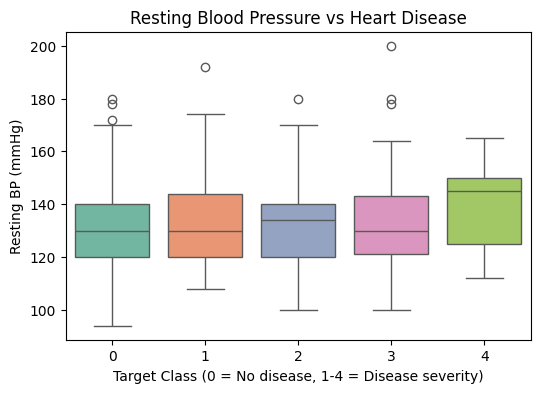

In [12]:
# ---------------------------
# Resting Blood Pressure vs Target
# ---------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x="target", y="trestbps", data=df_pandas, palette="Set2")
plt.title("Resting Blood Pressure vs Heart Disease")
plt.xlabel("Target Class (0 = No disease, 1-4 = Disease severity)")
plt.ylabel("Resting BP (mmHg)")
plt.show()


# Interpretation of Boxplots

## Target = 0 (No Disease):

Median resting BP ≈ 130 mmHg.

Most values fall between 120–140 mmHg.

A few outliers above 170 mmHg.

## Target = 1 (Mild Disease):

Median BP is slightly lower than “No disease,” around 128–130 mmHg.

Range spreads from 110–170 mmHg.

Outliers near 175+ mmHg.

## Target = 2 (Moderate Disease):

Median ≈ 135 mmHg, slightly higher than class 1.

Interquartile range (IQR) between 125–145 mmHg.

Outliers visible above 170 mmHg.

## Target = 3 (High Severity Disease):

Median ≈ 128 mmHg, close to class 1.

Spread is wider (110–150 mmHg).

Several outliers above 180–200 mmHg.

## Target = 4 (Most Severe Disease):

Median is noticeably higher ≈ 140–145 mmHg.

Range is broader (120–165 mmHg).

Outliers beyond 180 mmHg.

## Overall Observations

# General Trend:
Resting BP does not show a clear increasing trend with disease severity, unlike cholesterol. However, severe cases (class 4) have slightly higher median BP compared to others.

Overlap:
Most classes (0–3) overlap around 120–140 mmHg, suggesting resting BP alone is not a strong independent predictor of heart disease.

Outliers:
Multiple patients in each class have very high BP (>170 mmHg), especially in severe classes (3 & 4).

# 👉 Conclusion:
While there is some indication that severe heart disease (class 4) patients tend to have higher resting BP, the overlap across groups means that resting blood pressure alone is not sufficient to classify disease severity. It must be analysed in combination with other risk factors.

# Cholesterol vs Target

C:\Users\HP\AppData\Local\Temp\ipykernel_15940\3358981138.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="chol", data=df_pandas, palette="Set2")


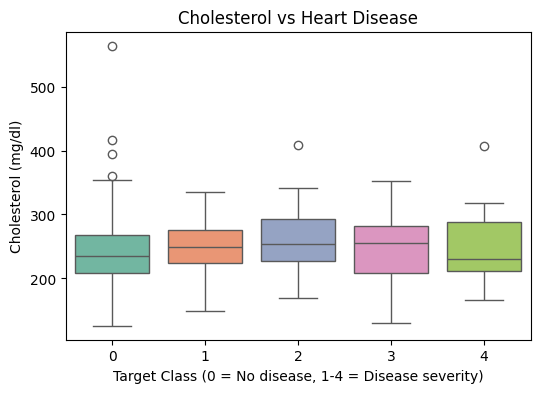

In [13]:
# ---------------------------
# Cholesterol vs Target
# ---------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x="target", y="chol", data=df_pandas, palette="Set2")
plt.title("Cholesterol vs Heart Disease")
plt.xlabel("Target Class (0 = No disease, 1-4 = Disease severity)")
plt.ylabel("Cholesterol (mg/dl)")
plt.show()

# Interpretation of Boxplots:

## Target Class 0 (No Disease):

Median cholesterol is around 240 mg/dl.

Wide spread, with outliers above 500 mg/dl.

Suggests some healthy patients still have very high cholesterol.

## Target Class 1 (Mild Disease):

Median around 250 mg/dl.

Distribution is tighter compared to class 0.

Still, some variation exists.

## Target Class 2 (Moderate Disease):

Median close to 250–260 mg/dl.

Similar spread to class 1, with fewer extreme outliers.

## Target Class 3 (Severe Disease):

Median around 250–260 mg/dl, slightly higher.

Distribution shows more lower values compared to other classes.

Outliers present around 400 mg/dl.

## Target Class 4 (Most Severe Disease):

Median around 240–250 mg/dl.

Similar spread to moderate/severe classes.

Few extreme high values.

# Key Insights:

Cholesterol levels do not vary drastically across disease severity levels (1–4).

Patients without disease (class 0) show wider variability in cholesterol, including extreme high values.

No clear upward trend of cholesterol with increasing disease severity.

This suggests cholesterol alone may not be a strong predictor of heart disease severity in this dataset, though high cholesterol is still a known risk factor.

# Max Heart Rate vs Target

C:\Users\HP\AppData\Local\Temp\ipykernel_15940\2390545081.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y="thalach", data=df_pandas, palette="Set2")


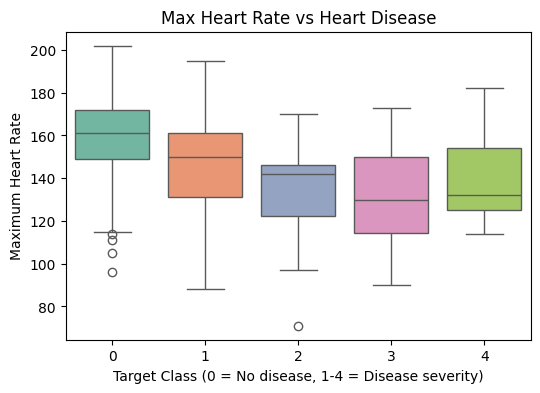

In [14]:
# ---------------------------
# Max Heart Rate vs Target
# ---------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x="target", y="thalach", data=df_pandas, palette="Set2")
plt.title("Max Heart Rate vs Heart Disease")
plt.xlabel("Target Class (0 = No disease, 1-4 = Disease severity)")
plt.ylabel("Maximum Heart Rate")
plt.show()

# Observations from the boxplot:

## Class 0 (No disease):

Median heart rate is around 165 bpm, higher than disease groups.

Distribution is wider, ranging roughly 100–200 bpm.

Outliers exist on the lower side (<120 bpm).

Suggests people without heart disease achieve higher heart rates.

## Class 1 (Mild disease):

Median around 150 bpm, lower than Class 0.

Range is 95–195 bpm.

Slight drop in max heart rate compared to healthy individuals.

## Class 2 (Moderate disease):

Median around 135 bpm.

Narrower interquartile range (IQR), around 125–150 bpm.

Outliers at lower side (~90 bpm).

Indicates further reduced capacity to reach higher heart rates.

## Class 3 (More severe disease):

Median around 130 bpm, still lower.

Distribution is wider (110–175 bpm).

Suggests more variability among patients at this severity level.

## Class 4 (Most severe disease):

Median ~130 bpm (similar to Class 3).

IQR between 125–150 bpm.

No extreme outliers.

Again confirms lower heart rate capacity in severe cases.

# 3. Key Insights:

Trend:
Maximum heart rate decreases as disease severity increases.

Healthy people (0) → Higher heart rates.

Severe cases (3, 4) → Lower heart rates.

# Clinical interpretation:
Lower maximum heart rate might indicate reduced cardiovascular fitness or impaired cardiac function in patients with heart disease.

Separation:

There is a clear distinction between healthy (0) and diseased (1–4) groups.

Within diseased groups (1–4), there is overlap, but severity generally correlates with lower heart rate medians.

# ✅ Final Interpretation:
People without heart disease generally achieve significantly higher maximum heart rates compared to those with heart disease. As disease severity progresses, maximum achievable heart rate tends to decline, suggesting reduced cardiovascular capacity. This supports using maximum heart rate as a useful indicator in diagnosing or predicting heart disease presence.

# Correlation heatmap

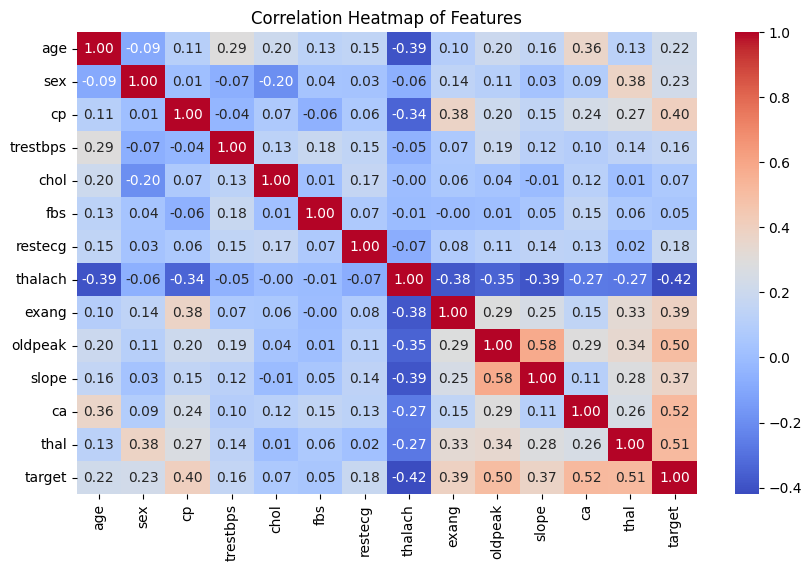

In [15]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_pandas.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

In [16]:
# ---- STEP 1: Compute correlation matrix ----
corr_matrix = df_pandas.corr()
corr_matrix

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.092399,0.110471,0.290476,0.202644,0.132062,0.149917,-0.394563,0.096489,0.197123,0.159405,0.362210,0.126586,0.222156
sex,-0.092399,1.000000,0.008908,-0.066340,-0.198089,0.038850,0.033897,-0.060496,0.143581,0.106567,0.033345,0.091925,0.383652,0.226797
cp,0.110471,0.008908,1.000000,-0.036980,0.072088,-0.057663,0.063905,-0.339308,0.377525,0.203244,0.151079,0.235644,0.268500,0.404248
trestbps,0.290476,-0.066340,-0.036980,1.000000,0.131536,0.180860,0.149242,-0.049108,0.066691,0.191243,0.121172,0.097954,0.138183,0.159620
chol,0.202644,-0.198089,0.072088,0.131536,1.000000,0.012708,0.165046,-0.000075,0.059339,0.038596,-0.009215,0.115945,0.010859,0.066448
fbs,0.132062,0.038850,-0.057663,0.180860,0.012708,1.000000,0.068831,-0.007842,-0.000893,0.008311,0.047819,0.152086,0.062209,0.049040
restecg,0.149917,0.033897,0.063905,0.149242,0.165046,0.068831,1.000000,-0.072290,0.081874,0.113726,0.135141,0.129021,0.018795,0.184136
thalach,-0.394563,-0.060496,-0.339308,-0.049108,-0.000075,-0.007842,-0.072290,1.000000,-0.384368,-0.347640,-0.389307,-0.268727,-0.274831,-0.420639
exang,0.096489,0.143581,0.377525,0.066691,0.059339,-0.000893,0.081874,-0.384368,1.000000,0.289310,0.250572,0.148232,0.326927,0.391613
oldpeak,0.197123,0.106567,0.203244,0.191243,0.038596,0.008311,0.113726,-0.347640,0.289310,1.000000,0.579037,0.294452,0.344976,0.501461


In [17]:
# Mean values of features for disease vs no disease
target_means = df_pandas.groupby("target").mean()
display(target_means)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,52.643750,0.556250,2.793750,129.175000,243.493750,0.143750,0.843750,158.581250,0.143750,0.598750,1.412500,0.275000,3.787500
1,55.611111,0.833333,3.333333,133.277778,249.148148,0.055556,1.148148,145.981481,0.444444,1.022222,1.629630,0.740741,5.314815
2,58.200000,0.800000,3.742857,134.371429,260.857143,0.228571,0.942857,135.000000,0.600000,1.802857,1.885714,1.257143,6.028571
3,56.000000,0.800000,3.771429,135.457143,246.457143,0.228571,1.285714,132.057143,0.657143,1.962857,1.971429,1.457143,6.285714
4,59.692308,0.846154,3.692308,138.769231,253.384615,0.076923,1.615385,140.615385,0.461538,2.361538,2.076923,1.692308,6.230769


# Key insights from this table

Age increases with disease severity

No disease group: ~52 years old.

Severe disease (4): ~60 years old.

👉 Older patients are more likely to have severe heart disease.

## Maximum Heart Rate (thalach) decreases with severity

No disease: ~158 bpm (higher capacity).

Severe disease: ~140 bpm.

👉 People with heart disease achieve lower peak heart rates.

## Oldpeak (ST depression) increases with severity

No disease: ~0.6.

Severe disease: ~2.36.

👉 ST depression is strongly linked to heart disease severity.

## Resting blood pressure & cholesterol rise slightly with disease

Treated as risk factors but not as clear a pattern as age/thalach.

## Slope, ca, thal also increase with severity

These features are medically relevant (exercise slope, vessels, thalassemia).

Higher averages reflect worsening condition.

Older age, lower max heart rate, higher oldpeak are clear indicators of disease.

# ANOVA Test

In [18]:
from scipy.stats import f_oneway

# Split ages into groups based on target levels
age_groups = [df_pandas[df_pandas["target"]==i]["age"] for i in df_pandas["target"].unique()]

# Perform one-way ANOVA
f_stat, p_val = f_oneway(*age_groups)

print("F-statistic:", f_stat, " P-value:", p_val)


F-statistic: 4.903412687229394  P-value: 0.0007692129218161172


# ANOVA Test (simple description)

The ANOVA test compares the means of a continuous variable across multiple groups.

# In our case: Age across disease severity levels (0–4).

Null hypothesis (H₀): All severity groups have the same mean Age.

Alternative (H₁): At least one group has a different mean Age.

Output:

F-statistic = 4.90 → variation between groups is ~5 times larger than variation within groups.

p-value ≈ 0.00077 (<0.05) → reject H₀.

# 👉 This means Age differs significantly across disease severity levels, but ANOVA does not tell which groups differ (post-hoc tests like Tukey HSD are needed for that).


# Chi-Square Test

In [19]:
from scipy.stats import chi2_contingency

# Example: Sex vs Target
contingency_table = pd.crosstab(df_pandas['sex'], df_pandas['target'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-square test p-value:", p)

Chi-square test p-value: 0.00011342960053440225


#  Chi-Square Test (simple description)

The Chi-square test of independence checks whether two categorical variables are related.

In our case: Sex (Male/Female) vs Target (disease severity 0–4).

Null hypothesis (H₀): Sex and disease severity are independent.

Alternative (H₁): Sex and disease severity are associated.

Since the p-value ≈ 0.0001 (<0.05), we reject H₀.
# 👉 This means disease severity levels are distributed differently across males and females (i.e., sex is related to severity).

# Feature Importance from Random Forest

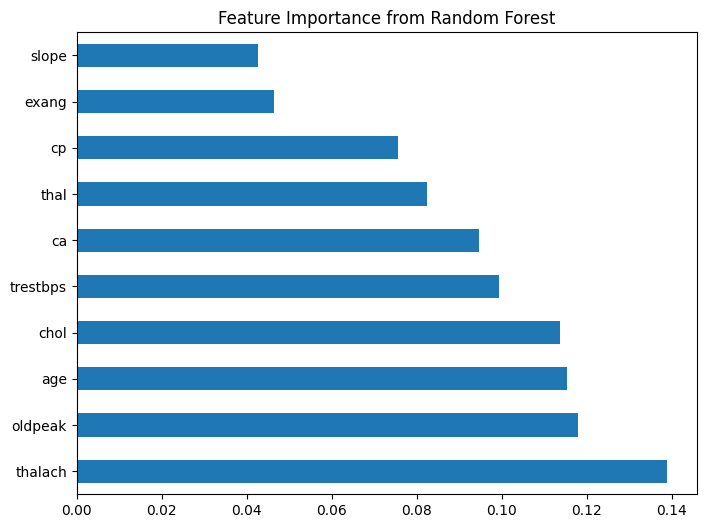

In [21]:
from sklearn.ensemble import RandomForestClassifier

X = df_pandas.drop("target", axis=1)
y = df_pandas["target"]

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Feature importance plot
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance from Random Forest")
plt.show()

# Explanation for the Chart
## What is Random Forest?

Random Forest is an ensemble machine learning algorithm used for classification and regression.

It builds many decision trees on random subsets of data and features.

Each tree votes, and the majority (for classification) or average (for regression) is the final prediction.

Because it uses multiple trees instead of one, it reduces overfitting and improves accuracy.

One useful output of Random Forest is feature importance – it tells us which features contribute the most to predicting the target.

# About the Chart

The chart above shows the top 10 most important features for predicting heart disease severity from patient data.

The length of each bar represents how much that feature helped reduce impurity (improving model predictions).

Larger values mean the feature was used more often and gave stronger splits across the trees.

# Explanation of Features (variables in the chart)

thalach (Maximum Heart Rate Achieved) – The most important factor (~0.14). Patients’ exercise heart rate is a strong indicator of heart health.

oldpeak (ST Depression Induced by Exercise) – Reflects ECG changes during exercise; high values indicate risk.

age – Older patients are at higher risk of heart disease.

chol (Serum Cholesterol) – Elevated cholesterol levels contribute to blockages.

trestbps (Resting Blood Pressure) – High resting BP can stress the heart.

ca (Number of Major Vessels Colored by Fluoroscopy) – The number of blocked vessels directly indicates disease severity.

thal (Thalassemia Test Result) – Test outcome related to blood disorder but correlated with heart conditions in this dataset.

cp (Chest Pain Type) – Type of chest pain (e.g., typical angina vs atypical) influences diagnosis.

exang (Exercise-Induced Angina) – Whether angina occurs during exercise; provides diagnostic information.

slope (Slope of Peak Exercise ST Segment) – Related to ECG slope during exercise; lower importance compared to others but still relevant.

# Summary

This chart tells us that maximum heart rate (thalach), exercise ECG depression (oldpeak), age, and cholesterol are the most influential predictors in this dataset. Features like slope and exang still matter but are less impactful.

## In short:
Random Forest shows us which patient features carry the most weight in predicting heart disease.